# Data Analyst vs. Data Scientist: Unveiling the Salary Divide in the World of Data

## Introduction

Understanding average salaries and differences between roles is crucial for making informed decisions aligning with personal aspirations and financial goals in a data-related career (Kaur et.al, 2022). Here we delve into the realm of data careers to compare the average income of employees (USD) in two different data-related roles (“ Data Analyst” vs “Data Engineer”) and  then determine if there’s a significant difference between the two groups. This will provide valuable insights for those seeking to carve their path in the world of data.

This dataset describes 12 attributes, of which we will focus on the specific ones listed below: 

`job_title` : The role worked during the year, focusing on “Data Analyst” and “ Data Science”.

`salary_in_usd`: The salary in USD. 

For our location parameter, we have chosen the mean to help determine the central tendency of the two groups and identify roles with higher or lower average salaries. The scale parameter, standard deviation, measures income variability. Comparing the standard deviations of the two groups reveals salary variation within each role: a smaller deviation indicates more consistency, while a larger deviation indicates greater variability. 

Since we are testing a second hypothesis, we want to see if theres a difference between the standards division. The standard deviation is essential for understanding the spread and variability of data within each group, as well as for comparing the consistency of salaries between different roles. It helps you quantify and analyze the dispersion of salary data, which is important when making inferences about potential differences between data analysts and data scientists. 

In terms of the mean,  the hypothesis test in this context is to determine if there is a significant difference in the average salaries of data analysts and data scientists. The mean is a fundamental statistical measure that helps you understand the central tendency of your data, make comparisons, conduct hypothesis tests, and summarize information about the average salaries for data analysts and data scientists in your analysis. 

We aim to assess whether any observed differences in the sample mean and standard deviation of the salaries between the two groups are due to random chance or if they represent a real difference in the population means. In order to fulfill the project requirements, at least two hypothesis tests are needed, with one utilizing bootstrapping and the other utilizing asymptotic methods.


### Using CLT to Test Difference in Means

Let $\bar{x}_1$ be the mean salary for a data analyst and $\bar{x}_2$ be the mean salary for a data engineer. Now, we can declare our two hypotheses:

$H_0$: $\bar{x}_1$ = $\bar{x}_2$. There is no significant difference in the average income between "Data Analyst” vs “Data Engineer”.  


$H_1$: $\bar{x}_1 \neq \bar{x}_2$. There is a significant difference in the average income between “Data Analyst” vs “Data Engineer”.  

### Using Bootstrapping to Test Difference in Standard Deviations

Let $\bar{\sigma}_1$ be the standard deviation of salary for a data analyst and $\bar{\sigma}_0$ be set to the standard deviation of salary for a data engineer which will be calculated using bootstrapping. Now, we can declare our two hypotheses:

$H_0$: $\bar{\sigma}_1$ = $\bar{\sigma}_0$. There is no significant difference in the standard deviation for income between "Data Analyst” vs “Data Engineer”. 


$H_1$: $\bar{\sigma}_1 \neq \bar{\sigma}_0$. There is a significant difference in the standard deviation for income between “Data Analyst” vs “Data Engineer”.

## Preliminary Results

In [297]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(scales)
library(cowplot)
library(digest)

In [298]:
# setting seed for entire project
set.seed(4850)

Download the dataset from the url and store it into a local file.

In [299]:
url = 'https://raw.githubusercontent.com/aaryan-rampal/stat-201-project/main/data/ds_salaries.csv'

download.file(url, destfile = "data/ds_salaries.csv")

Read the file into the dataframe `salary_original`. We will need to wrangle this original dataframe by selecting our columns of interest and filtering `NA` values. 

In [300]:
salary_original <- read_csv("data//ds_salaries.csv")

# clean up columns 
salary <- salary_original |>
    select(job_title, salary_in_usd) |>
    filter(!is.na(salary_in_usd), 
           !is.na(job_title),
           (job_title == "Data Analyst" | job_title == "Data Scientist")) |>
    # overwrite job_title to be of type factor
    mutate(job_title = as_factor(job_title)) 

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [301]:
head(salary, 6)
table(select(salary, job_title))

job_title,salary_in_usd
<fct>,<dbl>
Data Scientist,79833
Data Analyst,72000
Data Scientist,35735
Data Scientist,51321
Data Scientist,40481
Data Scientist,39916



Data Scientist   Data Analyst 
           143             97 

It looks like `salary` has been wrangled properly and contains a fair amount of datapoints for both job titles. 

Let's visualize the sampling distribution of salaries for both jobs. 

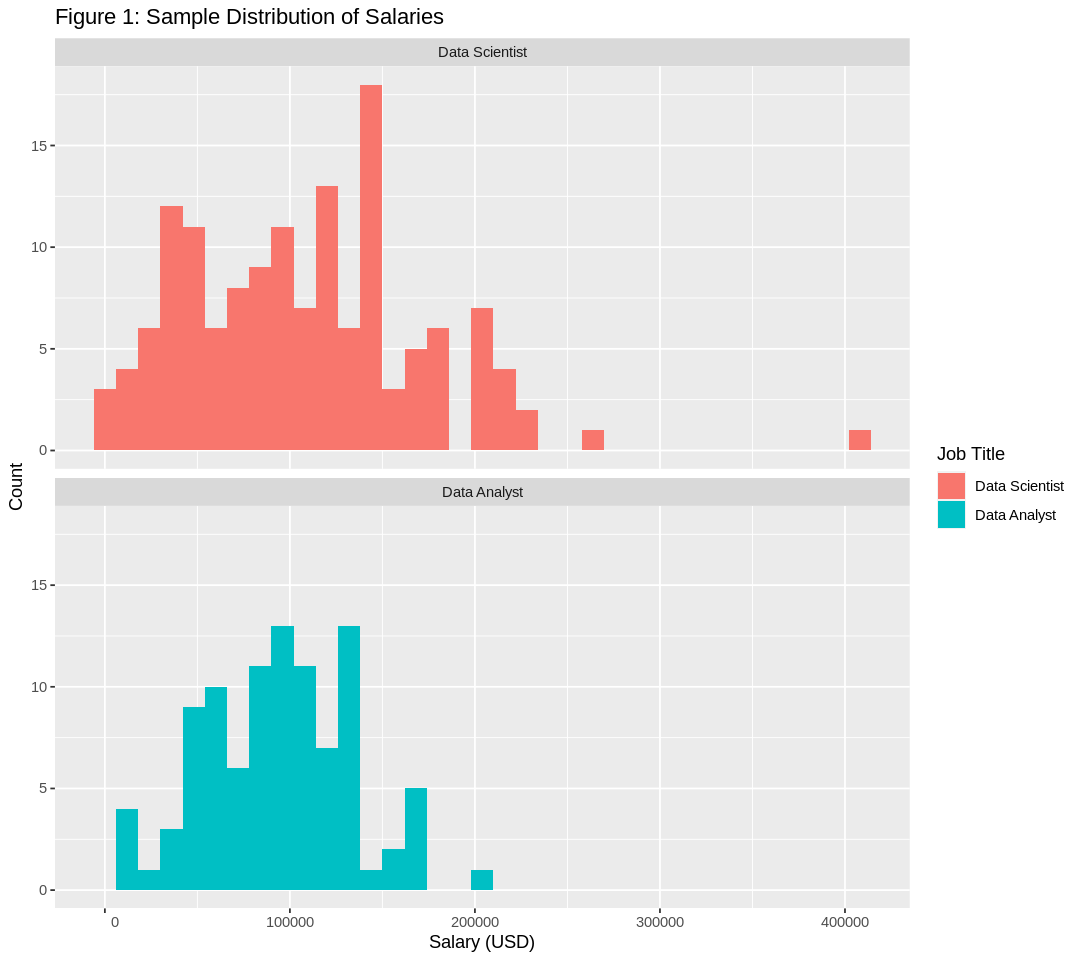

In [302]:
options(repr.plot.height = 8, repr.plot.width = 9)

# visualization of original data sample
salary_sample_dist <- salary |>
    ggplot(aes(x = salary_in_usd, fill = job_title)) +
    geom_histogram(binwidth = 12000) +
    facet_wrap(~ job_title, ncol = 1) +
    ggtitle("Figure 1: Sample Distribution of Salaries") +
    xlab("Salary (USD)") +
    ylab("Count") +
    labs(fill = "Job Title") + 
    scale_x_continuous(labels = function(x) format(x, scientific = FALSE))

salary_sample_dist

The sampling distribution for both job titles appears to be pretty similar, though it does seem there are quite a few data scientists that are paid more than data analysts. This could also just be the outliers in our data, let's visualize our data using a boxplot to gain more information.

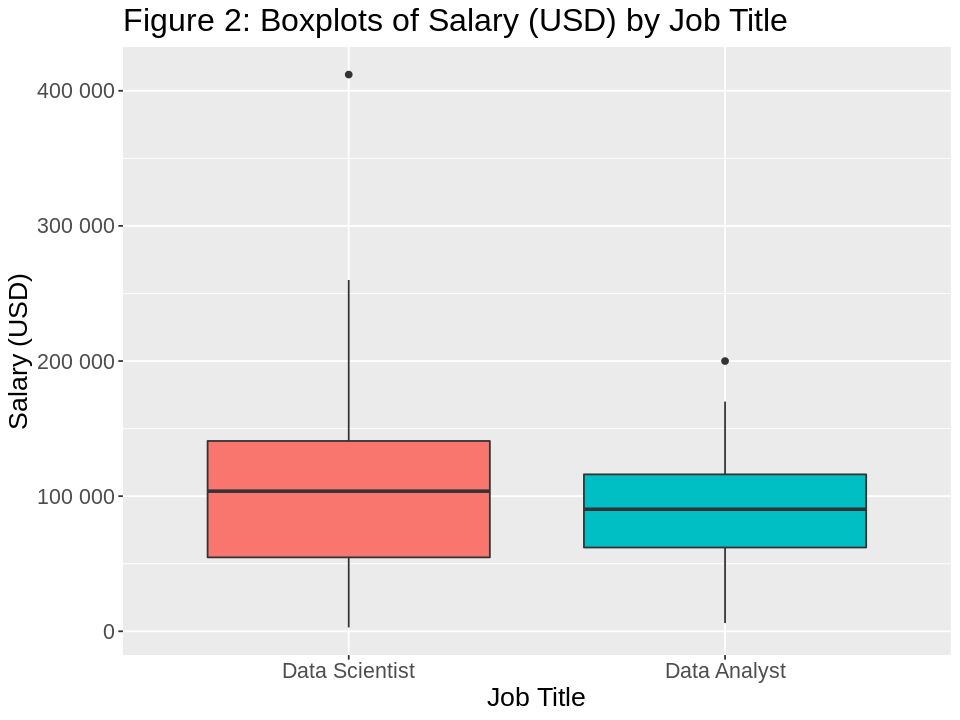

In [303]:
options(repr.plot.height = 6, repr.plot.width = 8)

salary_boxplot <-
    salary %>% 
    ggplot() +
    geom_boxplot(aes(job_title, salary_in_usd, fill=job_title)) +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2: Boxplots of Salary (USD) by Job Title") + 
    xlab("Job Title") + 
    ylab("Salary (USD)") +  
    guides(fill = "none") +
    scale_y_continuous(labels = label_number(scale = 1))

salary_boxplot

As can be seen, it looks like the mean values for salary for both job titles is very similar. The data analyst box plot seems to be more tightly populated than the data scientist box plot, hinting at a smaller standard deviation.

Moreover, we can see the extent of the data scientist outliers. There is an outlier at around $400,000 USD which is quite far outside the range of normal values for data scientist. This could be the reason why the data scientist mean salary is greater than the data analyst's. 

At a preliminary glance, it looks like data analysts are paid less on average when compared to data scientists. But is this difference significant? This is what we shall attempt to find out.

## Methods: Plan

Given our approach using hypothesis testing to compare the average income of roles titled “Data Analyst” and “Data Engineer”, we are testing our assumptions prior to actuating them. This results in a trustworthy report as the premises carried over from the hypothesis test will be verified for future implementation to the broader population. 

Although current visualizations and estimates provide a brief understanding of the Data Science Job Salaries dataset, they cannot be generalized or alluded to the entire field of data-related careers. As we plan to carry out a hypothesis test upon the average income for both roles of “Data Analyst” and “Data Engineer”, a confidence interval will also be constructed for sampling distributions of the average income for both job titles. We expect to estimate the true population parameter of mean income for “Data Analysts” and “Data Engineers” as well as test our hypothesis that the average income for the two job titles are significantly different. 

This report is intended to provide support for those making choices about the pursuit of one’s profession and may evidently lead to questions regarding the difference in difficulty or commitment of data-related careers based on the income.

In [304]:
# compute summary statistics for each job title
salary_summarized <- salary |>
    group_by(job_title) |>
    summarize(n = n(),
              sample_mean = mean(salary_in_usd),
              sample_var = sd(salary_in_usd)^2)

salary_summarized

job_title,n,sample_mean,sample_var
<fct>,<int>,<dbl>,<dbl>
Data Scientist,143,108187.83,4110456319
Data Analyst,97,92893.06,1596887583


### Testing Difference in Means

The distributions of our sample means for data scientists and data analysts are unknown, but to 
apply CLT, we assume that our sample sizes for the respective samples are large enough to validate
Normal approximation. We are also assuming that the two samples are independent and that they are 
randomly drawn. By these assumptions of independence and CLT, we can use the calculated statistics 
from above to caluclate our test statistic for the two-sampled t-test.

The distributions of our sample means for data scientists and data analysts are unknown, but our sample sizes $n_1 = 143$ and $n_2 = 97$ for the respective samples are sufficiently large enough to validate Normal approximation by CLT. We are also assuming that the two samples are independent and that they are randomly drawn. By these assumptions of independence and CLT, we can use the calculated statistics from above to caluclate our test statistic for the two-sampled t-test.

In [305]:
# pull the sample statistics from our computed dataframe
sample_mean1 <- salary_summarized$sample_mean[1]
sample_mean2 <- salary_summarized$sample_mean[2]

sample_var1 <- salary_summarized$sample_var[1]
sample_var2 <- salary_summarized$sample_var[2]

n1 <- salary_summarized$n[1]
n2 <- salary_summarized$n[2]

# calculate our two-sample t-test statistic
test_statistic <- (sample_mean1 - sample_mean2) /
        (sqrt(sample_var1 / n1 + 
             sample_var2 / n2))

# generate degrees of freedom 
df <- n1 + n2 - 2

test_statistic

[1] 2.274778

Our test statistic is approximately 2.27477849905754. 

~~This is extremely large for a z-score test statistic. 99.7% of the values in a null model fall under a z-score of -3 to 3, so we can already tell that the p-value for out test statistic will be very close to, if not absolutely~~

~~Regardless, let's carry out the action of acquiring the p-value. Note that we are subtracting `pnorm` from 1 to find the p-value for anything equal to or greater than our test statistic, then multiplying it by 2 to make it a two-tailed p-value.~~

In [316]:
p_value_two_sided <- 2 * (1 - pt(test_statistic, df = df))

p_value_two_sided

[1] 0.02380969

As expected, our p value is 0.0238. This means that, under a 5% significance level, there is a statistically significant difference between the population mean salary between data scientists and data analysts. 

~~However, p values being 0 should raise alarm bells. This means that there is absolutely no chance that the result which we acquired should be possible. We should be very careful before being absolutely sure about something in statistics.~~

~~We will talk more about the limitations of our results in the discussion section, but it is worth noting that we had some outliers for data scientists which could have severly distorted the data and thus our p-value.~~

### TESTING DIFFERENCE IN STANDARD DEVIATION

We would like to also examine the difference between our scale parameter of choice, the standard deviation of salary for the two job titles of “Data Analyst” and “Data Engineer”. Aforementioned in our introduction, the standard deviation will reveal income variability which can tell us whether the difference in spread between the two populations is truly different or not. Let's focus on the standard deviation of data scientists and test if this measure of spread is truly different from that of data analysts. To test this difference, we will carry out a bootstrap hypothesis test using a significance level of $\alpha = 0.05$ on the difference in standard deviation, as follows.

Since we do not know either the true standard deviation for data analysts and data scientists, let us first use bootstraping to approximate the sampling distribution of data analysts. We will set the true standard deviation for data analysts to the mean of this sampling distribution for the purpose of our hypothesis test

In [307]:
set.seed(4850)


# create single sample of data analysts from filtering only that job title 
data_analyst <- salary |>
    filter(job_title == "Data Analyst") 

# use bootstrapping to calculate standard deviation for 1000 bootstrapped samples
data_analyst_bootstrap <- data_analyst |>
    specify(response = salary_in_usd) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate("sd")

# by CLT, the mean of the bootstrap distribution is equal to the true population parameter
sd_data_analyst <- data_analyst_bootstrap |>
    summarise(true_sd = mean(stat)) 

sd_data_analyst

true_sd
<dbl>
39656.81


As bootstrap distributions are a good estimate of sampling distributions, and assuming that our original sample for data analysts of $n = 97$ is sufficiently large, we estimate the true standard deviation for data analysts to be $\sigma_2 = 39656.81$. We will use this value to carry out a hypothesis test on the standard deviation for data scientists where the true standard deviation is also unknown. 

Let $\sigma_1$ be the standard deviation of salary for a data scientist and $\sigma_0$ be equal to $\sigma_2 = 39656.81$ which is the true standard deviation of salary for a data analyst. Now, we can declare our null and alternate hypotheses:

$H_0$: $\sigma_1$ = $39656.81$. The standard deviation of salaries for data scientists is equal to that of data analysts.

$H_1$: $\sigma_1 \neq 39656.81$. There is a difference in the standard deviation of salaries between a data analyst and data scientists.

In [308]:
set.seed(4850)


# sigma_0 <- 39656.81
sigma_0 <- sd_data_analyst
sigma_0

# create data frame of only data scientists
data_scientist <- salary |>
    filter(job_title == "Data Scientist")

# simulating from null distribution 
null_data_scientist <- data_scientist |>
  specify(response = salary_in_usd) |>
  hypothesize(null = "point", sigma = sigma_0) |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "sd")

head(null_data_scientist)

true_sd
<dbl>
39656.81


replicate,stat
<int>,<dbl>
1,62941.44
2,67036.35
3,59592.86
4,61174.15
5,64092.49
6,66189.81


Now that we have the simulated null distribution, we will use the standard deviation of the data scientists sample for our test statistic.

In [309]:
set.seed(4850)


# get the observed test statistic which is the standard deviation of the original sample for data scientists
obs_test_stat <- data_scientist |>
    summarise(sd = sd(salary_in_usd)) |>
    pull()

obs_test_stat

[1] 64112.84

Plotting the result of the hypothesis test from above.

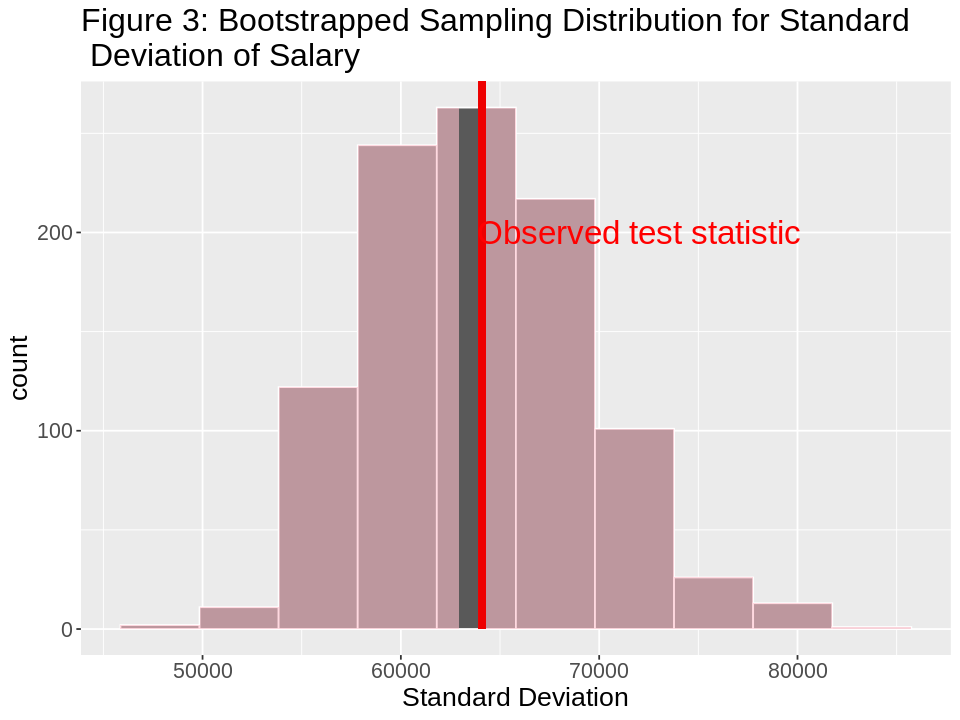

In [310]:
set.seed(4850)


data_scientist_plot <-  
    null_data_scientist %>% 
    visualize(bins = 10) + 
    shade_p_value(obs_stat = obs_test_stat, direction = "both") +
    xlab("Standard Deviation") + 
    ggtitle("Figure 3: Bootstrapped Sampling Distribution for Standard\n Deviation of Salary") +
    theme(text = element_text(size=16)) + 
    annotate("text", x = 72000, y = 200, label = "Observed test statistic", color="red", size=7)

data_scientist_plot

By the definition of the p-value, it looks like it will be very large visually inferred from the plot above. Let's get a numerical value for the p-value next.


In [311]:
set.seed(4850)

p_value <- null_data_scientist |>
    get_p_value(obs_stat = obs_test_stat, direction = "both")

p_value

p_value
<dbl>
0.924


Given our pre-sepcified $\alpha = 0.05$, the p-value is significantly greater than that. Thus, we conclude that we fail to reject the null hypothesis, $H_0$, and that there is not enough evidence to support that there is a difference in the true standard deviations of salary for data scientists and data analysts.


## Discussion

In this project, the main objective was to compare the average income between two data-related roles: “Data Analyst” and “Data Scientist”, as well as to investigate the potential differences in the standard deviation(income variability) between these roles. The initial analysis revealed that Data Scientists had an average salary of approximately $\$$108,187.83, while Data Analysts earned around $\$$92,893.06 on average. A two-sample t-test was conducted to determine if this observed difference was statistically significant. The p-value obtained from the t-test was less than 0.05, indicating strong evidence against the null hypothesis. Therefore, it can be concluded that there is a statistically significant difference in the average income between Data Scientists and Data Analysts. Data Scientists tend to earn significantly higher average salaries compared to Data Analysts. Another aspect investigated was the variability in income, measured by the standard deviation. The hypothesis test using bootstrapping aimed to determine if the standard deviation of Data Scientists' salaries was significantly different from that of Data Analysts. The calculated p-value was approximately 0.916, exceeding the preset significance level of 0.05. As a result, there was insufficient evidence to reject the null hypothesis, indicating that the true salary standard deviations of Data Scientists and Data Analysts are not significantly different. This implies that the income variability between the two roles does not exhibit a statistically significant discrepancy.

The obtained results are in line with our initial expectations. In the industry, Data Scientist roles are typically perceived as more intricate and specialized compared to Data Analyst roles, which naturally leads to the observed higher average income for Data Scientists. Additionally, the absence of a significant difference in income variability between the two roles implies that the factors impacting salary variability are not significantly divergent for Data Scientists and Data Analysts.

The outcomes of this project carry substantial implications for individuals contemplating careers in data analysis or data science. These findings offer valuable insights to individuals seeking well-informed career paths by highlighting potential income distinctions between roles as Data Analysts and Data Scientists. The notably higher average salary observed among Data Scientists could significantly impact career decisions, particularly for those aspiring to maximize their earning potential. Furthermore, these results have the potential to foster deeper contemplation among individuals regarding the distinct skill sets, responsibilities, and expertise inherent to Data Analyst and Data Scientist roles. The higher average income among Data Scientists might very well mirror the necessity for more intricate and advanced skill sets essential for excelling in their specialized roles. 

The research opens avenues for further exploration into role responsibilities, career progression, and industry-specific influences on income disparities in data-related careers.


## References

T. Z. Quan and M. Raheem, "Salary Prediction in Data Science Field Using Specialized Skills and Job Benefits–A Literature", Journal of Applied Technology and Innovation, vol. 6, no. 3, pp. 70-74, 2022, ISSN 2600-7304.

A. Kaur, D. Verma and N. Kaur, "Utilizing Quantitative Data Science Salary Analysis to Predict Job Salaries," 2022 2nd International Conference on Innovative Sustainable Computational Technologies (CISCT), Dehradun, India, 2022, pp. 1-4, doi: 10.1109/CISCT55310.2022.10046491.